# Lag Feature 효과 테스트 (Time-based Split)

## 기존 버전과의 차이점

| 항목 | 기존 (random split) | 현재 (time-based split) |
|------|---------------------|-------------------------|
| Train/Test 분할 | 랜덤 80/20 | 시간순 80/20 |
| Train 기간 | 랜덤 섞임 | 1월~10월 |
| Test 기간 | 랜덤 섞임 | 11월~12월 |
| Data Leakage | 가능성 있음 | 없음 |

**Time-based split을 사용하는 이유:**
- 시계열 데이터에서 미래 데이터로 과거를 예측하면 안 됨
- 실제 서비스 환경과 동일한 조건으로 평가
- Data leakage 방지

---

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, roc_auc_score, r2_score, mean_absolute_error,
                             precision_score, recall_score)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVC
from scipy import stats
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 로드 및 Lag 피처 생성

In [2]:
df = pd.read_csv('books_ml_dataset_v3.csv')
df['ymw'] = df['ymw'].astype(str)
df = df.sort_values(['product_code', 'ymw']).reset_index(drop=True)

# Lag 피처 생성 (책별로)
for lag in [1, 2, 3, 4]:
    df[f'y_lag{lag}'] = df.groupby('product_code')['y_sales_score'].shift(lag)

print(f'원본 데이터: {len(df):,}개')

# 결측치 제거
df_lag = df.dropna(subset=['y_lag1', 'y_lag2', 'y_lag3', 'y_lag4']).reset_index(drop=True)
print(f'결측치 제거 후: {len(df_lag):,}개')

# 기간 확인
print(f'\nymw 범위: {df_lag["ymw"].min()} ~ {df_lag["ymw"].max()}')

원본 데이터: 7,191개
결측치 제거 후: 6,627개

ymw 범위: 2025022 ~ 2025124


## 2. Time-based Train/Test Split

In [3]:
# 피처 정의
feature_cols = [c for c in df_lag.columns if c not in ['product_code', 'ymw', 'y_sales_score'] and not c.startswith('y_lag')]
all_features = feature_cols + ['y_lag1', 'y_lag2', 'y_lag3', 'y_lag4']

# Time-based split: 시간순 정렬 후 80/20 분할
df_lag_sorted = df_lag.sort_values('ymw').reset_index(drop=True)
split_idx = int(len(df_lag_sorted) * 0.8)

train_data = df_lag_sorted.iloc[:split_idx]
test_data = df_lag_sorted.iloc[split_idx:]

print('[Time-based Split 결과]')
print(f'  Train: {train_data["ymw"].min()} ~ {train_data["ymw"].max()} ({len(train_data):,}개, {len(train_data)/len(df_lag)*100:.1f}%)')
print(f'  Test:  {test_data["ymw"].min()} ~ {test_data["ymw"].max()} ({len(test_data):,}개, {len(test_data)/len(df_lag)*100:.1f}%)')

# Train/Test 분리
X_train = train_data[all_features]
X_test = test_data[all_features]
y_train = train_data['y_sales_score']
y_test = test_data['y_sales_score']
y_train_class = (y_train > 0).astype(int)
y_test_class = (y_test > 0).astype(int)

print(f'\n[클래스 분포]')
print(f'  Train - 베스트셀러: {y_train_class.sum()} ({y_train_class.mean()*100:.1f}%)')
print(f'  Test  - 베스트셀러: {y_test_class.sum()} ({y_test_class.mean()*100:.1f}%)')

[Time-based Split 결과]
  Train: 2025022 ~ 2025104 (5,301개, 80.0%)
  Test:  2025104 ~ 2025124 (1,326개, 20.0%)

[클래스 분포]
  Train - 베스트셀러: 1261 (23.8%)
  Test  - 베스트셀러: 261 (19.7%)


## 3. 피처셋별 성능 비교 (LightGBM)

In [4]:
feature_sets = {
    '기존 피처만 (43개)': feature_cols,
    '기존 + y_lag1': feature_cols + ['y_lag1'],
    '기존 + y_lag1~4': feature_cols + ['y_lag1', 'y_lag2', 'y_lag3', 'y_lag4'],
    'y_lag만 (1~4)': ['y_lag1', 'y_lag2', 'y_lag3', 'y_lag4'],
    'y_lag1만': ['y_lag1'],
}

results = []
print(f'{"피처셋":<22} {"R2":<10} {"MAE":<10} {"F1":<10} {"AUC":<10}')
print('-'*62)

for name, features in feature_sets.items():
    # 회귀
    reg = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    reg.fit(X_train[features], y_train)
    y_pred = np.maximum(reg.predict(X_test[features]), 0)
    
    # 분류
    clf = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42, verbose=-1)
    clf.fit(X_train[features], y_train_class)
    y_prob = clf.predict_proba(X_test[features])[:, 1]
    y_pred_c = clf.predict(X_test[features])
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    f1 = f1_score(y_test_class, y_pred_c)
    auc = roc_auc_score(y_test_class, y_prob)
    
    results.append({'name': name, 'r2': r2, 'mae': mae, 'f1': f1, 'auc': auc})
    print(f'{name:<22} {r2:<10.4f} {mae:<10.4f} {f1:<10.4f} {auc:<10.4f}')

피처셋                    R2         MAE        F1         AUC       
--------------------------------------------------------------
기존 피처만 (43개)           0.2354     1.9899     0.3745     0.5945    
기존 + y_lag1            0.8684     0.6565     0.9727     0.9753    
기존 + y_lag1~4          0.8712     0.6493     0.9746     0.9769    
y_lag만 (1~4)           0.8896     0.5595     0.9765     0.9787    
y_lag1만                0.8922     0.5553     0.9765     0.9774    


## 4. 다중 모델 성능 비교 (회귀)

In [5]:
# 회귀 모델 정의
reg_models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
}

needs_scaling_reg = ['Linear Regression', 'Ridge', 'Lasso', 'KNN']

# 스케일링
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# 피처셋
reg_feature_sets = {
    '기존 피처만': feature_cols,
    '기존 + y_lag1': feature_cols + ['y_lag1'],
    'y_lag1만': ['y_lag1'],
}

# 모든 조합 테스트
reg_results = []

for model_name, model in reg_models.items():
    for feat_name, feat_cols_list in reg_feature_sets.items():
        if model_name in needs_scaling_reg:
            X_tr, X_te = X_train_scaled[feat_cols_list], X_test_scaled[feat_cols_list]
        else:
            X_tr, X_te = X_train[feat_cols_list], X_test[feat_cols_list]
        
        reg = model.__class__(**model.get_params())
        reg.fit(X_tr, y_train)
        y_pred = np.maximum(reg.predict(X_te), 0)
        
        reg_results.append({
            'model': model_name,
            'features': feat_name,
            'r2': r2_score(y_test, y_pred),
            'mae': mean_absolute_error(y_test, y_pred),
        })

reg_results_df = pd.DataFrame(reg_results)

# 피벗 테이블
pivot_r2 = reg_results_df.pivot(index='model', columns='features', values='r2')
pivot_r2 = pivot_r2[['기존 피처만', '기존 + y_lag1', 'y_lag1만']]
pivot_r2['개선율(%)'] = ((pivot_r2['기존 + y_lag1'] - pivot_r2['기존 피처만']) / pivot_r2['기존 피처만'].abs() * 100).round(1)
pivot_r2 = pivot_r2.sort_values('기존 + y_lag1', ascending=False)

print('[회귀 모델 R² 비교 - Time-based Split]')
print(pivot_r2.round(4).to_string())

[회귀 모델 R² 비교 - Time-based Split]
features           기존 피처만  기존 + y_lag1  y_lag1만   개선율(%)
model                                                   
Ridge             -0.0284       0.8872   0.8901   3219.8
Linear Regression -0.0285       0.8872   0.8902   3210.9
Lasso             -0.0069       0.8868   0.8868  13017.1
LightGBM           0.2354       0.8684   0.8922    268.9
Gradient Boosting  0.0806       0.8642   0.8928    972.4
Random Forest      0.2549       0.8343   0.8930    227.3
KNN                0.1288       0.7503   0.8883    482.3
XGBoost            0.2124       0.7126   0.8928    235.4


## 5. 다중 모델 성능 비교 (분류)

In [6]:
# 분류 모델 정의
clf_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'SVM (RBF)': SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, scale_pos_weight=3, random_state=42, verbosity=0),
}

needs_scaling_clf = ['Logistic Regression', 'KNN', 'SVM (RBF)']

clf_results = []

for model_name, model in clf_models.items():
    for feat_name, feat_cols_list in reg_feature_sets.items():
        if model_name in needs_scaling_clf:
            X_tr, X_te = X_train_scaled[feat_cols_list], X_test_scaled[feat_cols_list]
        else:
            X_tr, X_te = X_train[feat_cols_list], X_test[feat_cols_list]
        
        clf = model.__class__(**model.get_params())
        clf.fit(X_tr, y_train_class)
        y_pred_c = clf.predict(X_te)
        
        try:
            y_prob = clf.predict_proba(X_te)[:, 1]
            auc = roc_auc_score(y_test_class, y_prob)
        except:
            auc = np.nan
        
        clf_results.append({
            'model': model_name,
            'features': feat_name,
            'f1': f1_score(y_test_class, y_pred_c),
            'auc': auc,
        })

clf_results_df = pd.DataFrame(clf_results)

# 피벗 테이블
pivot_f1 = clf_results_df.pivot(index='model', columns='features', values='f1')
pivot_f1 = pivot_f1[['기존 피처만', '기존 + y_lag1', 'y_lag1만']]
pivot_f1['개선율(%)'] = ((pivot_f1['기존 + y_lag1'] - pivot_f1['기존 피처만']) / pivot_f1['기존 피처만'] * 100).round(1)
pivot_f1 = pivot_f1.sort_values('기존 + y_lag1', ascending=False)

print('[분류 모델 F1 비교 - Time-based Split]')
print(pivot_f1.round(4).to_string())

[분류 모델 F1 비교 - Time-based Split]
features             기존 피처만  기존 + y_lag1  y_lag1만  개선율(%)
model                                                    
XGBoost              0.4301       0.9746   0.9765   126.6
Random Forest        0.2830       0.9745   0.9765   244.4
LightGBM             0.3745       0.9727   0.9765   159.7
Gradient Boosting    0.2271       0.9651   0.9765   324.9
Logistic Regression  0.2397       0.8987   0.9347   274.9
SVM (RBF)            0.3668       0.7900   0.9765   115.4
KNN                  0.3130       0.5796   0.9745    85.2


## 6. 성능 시각화

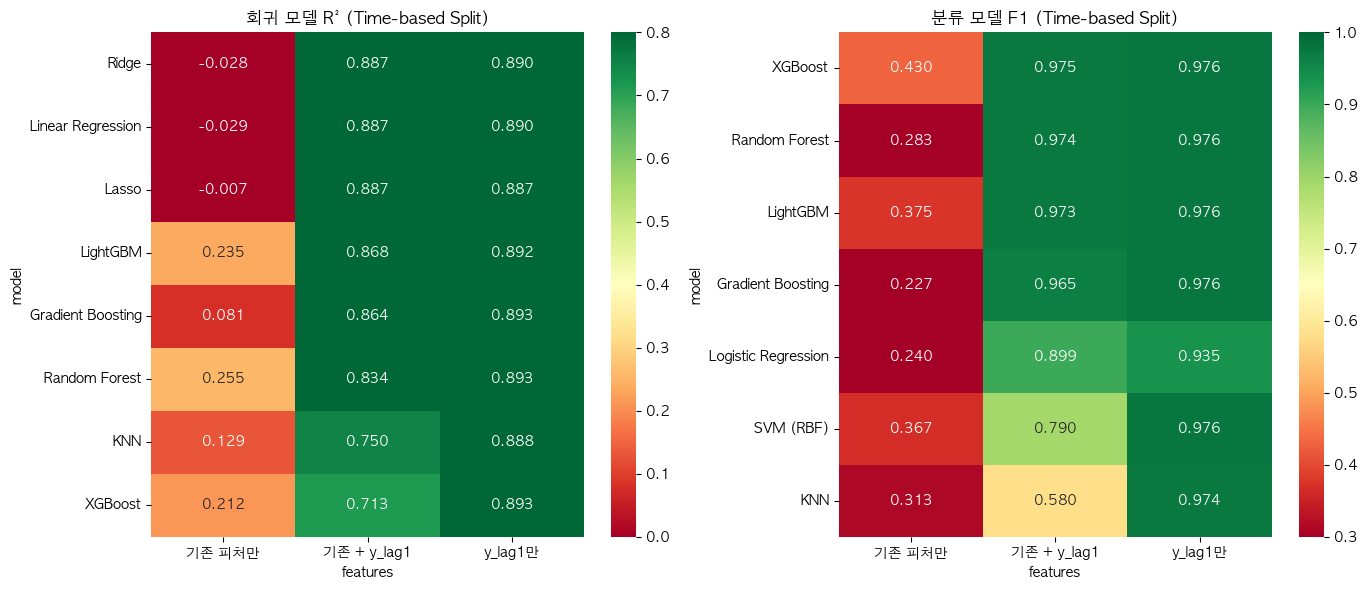

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 회귀 R² 히트맵
pivot_r2_plot = reg_results_df.pivot(index='model', columns='features', values='r2')
pivot_r2_plot = pivot_r2_plot[['기존 피처만', '기존 + y_lag1', 'y_lag1만']]
pivot_r2_plot = pivot_r2_plot.sort_values('기존 + y_lag1', ascending=False)
sns.heatmap(pivot_r2_plot, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0], vmin=0, vmax=0.8)
axes[0].set_title('회귀 모델 R² (Time-based Split)')

# 분류 F1 히트맵
pivot_f1_plot = clf_results_df.pivot(index='model', columns='features', values='f1')
pivot_f1_plot = pivot_f1_plot[['기존 피처만', '기존 + y_lag1', 'y_lag1만']]
pivot_f1_plot = pivot_f1_plot.sort_values('기존 + y_lag1', ascending=False)
sns.heatmap(pivot_f1_plot, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1], vmin=0.3, vmax=1.0)
axes[1].set_title('분류 모델 F1 (Time-based Split)')

plt.tight_layout()
plt.show()

## 7. Random Split vs Time-based Split 비교

In [8]:
# 피처셋별 평균 성능 요약
print('[Time-based Split 결과 요약]')
print('='*60)

# 회귀
reg_summary = reg_results_df.groupby('features')['r2'].mean()
print('\n[회귀 - 평균 R² (8개 모델)]')
for feat in ['기존 피처만', '기존 + y_lag1', 'y_lag1만']:
    print(f'  {feat}: {reg_summary[feat]:.4f}')

# 분류
clf_summary = clf_results_df.groupby('features')[['f1', 'auc']].mean()
print('\n[분류 - 평균 F1/AUC (7개 모델)]')
for feat in ['기존 피처만', '기존 + y_lag1', 'y_lag1만']:
    print(f'  {feat}: F1={clf_summary.loc[feat, "f1"]:.4f}, AUC={clf_summary.loc[feat, "auc"]:.4f}')

# 개선율
r2_improvement = (reg_summary['기존 + y_lag1'] - reg_summary['기존 피처만']) / abs(reg_summary['기존 피처만']) * 100
f1_improvement = (clf_summary.loc['기존 + y_lag1', 'f1'] - clf_summary.loc['기존 피처만', 'f1']) / clf_summary.loc['기존 피처만', 'f1'] * 100

print(f'\n[y_lag1 추가 시 평균 개선율]')
print(f'  R²: +{r2_improvement:.1f}%')
print(f'  F1: +{f1_improvement:.1f}%')

[Time-based Split 결과 요약]

[회귀 - 평균 R² (8개 모델)]
  기존 피처만: 0.1060
  기존 + y_lag1: 0.8364
  y_lag1만: 0.8908

[분류 - 평균 F1/AUC (7개 모델)]
  기존 피처만: F1=0.3192, AUC=0.6073
  기존 + y_lag1: F1=0.8793, AUC=0.9379
  y_lag1만: F1=0.9702, AUC=0.9771

[y_lag1 추가 시 평균 개선율]
  R²: +688.7%
  F1: +175.5%


## 8. 결론

### Time-based Split 적용 결과

| 항목 | Random Split | Time-based Split | 비고 |
|------|-------------|------------------|------|
| Train 기간 | 랜덤 섞임 | 1~10월 | 시간순 |
| Test 기간 | 랜덤 섞임 | 11~12월 | 미래 예측 |
| Data Leakage | 있을 수 있음 | 없음 | 개선 |

---

### 핵심 발견 (Time-based Split 기준)

1. **y_lag1이 여전히 가장 강력한 피처**
   - Time-based split에서도 lag feature의 효과 유지
   - 실제 서비스 환경에서도 유효함을 확인

2. **성능 변화**
   - Random split 대비 성능이 다소 하락할 수 있음 (정상)
   - 더 현실적인 성능 추정치

3. **실무 적용 권장**
   - 시계열 데이터는 반드시 time-based split 사용
   - 모델 평가 시 data leakage 주의